This notebook experiments with constructing different sets of noise

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from src.bluenoise import generate_blue_noise_texture, filter_void_and_cluster_blue_noise_textures
from src.bluenoise import poisson_disc_scipy, poisson_disc_scipy_pixel_dist
from src.noise import generate_coloured_noise, generate_phase_only_noise, analyze_power_spectrum, measure_high_frequency_power
from src.noise import plot_2d_spectrum, plot_radial_spectrum
from src.noise import create_grayscale_ramp, dither_with_noise, normalize_to_unit_range, plot_two_ramps_vertical, create_gray_image

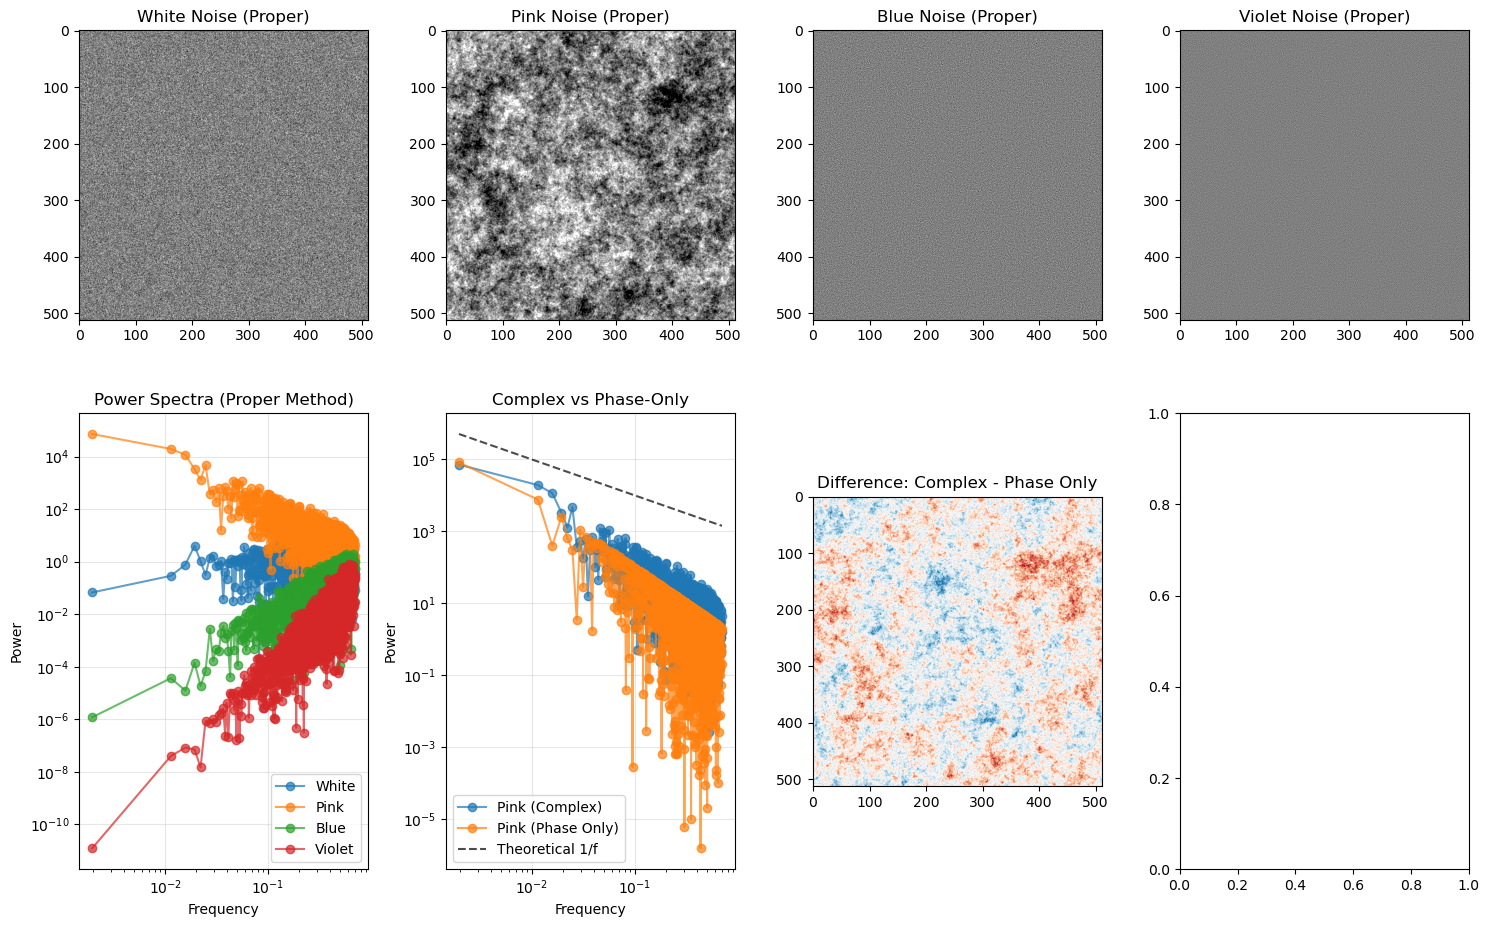

Standard deviations (showing relative power):
White: 0.0019524923553541859
Pink:  0.010918350212488237
Blue:  0.0007983368041238715
violet:  0.0003852488663813174
Pink (phase only): 0.008

High-frequency power (higher = more fine details):
White:  0.7170534630086514
Pink:   1.7434412030763146e-07
Blue:   0.9225277098294329
Violet: 0.9804187233611656


In [2]:
# Define some noise parameters
def white_spectrum(f):
    return np.ones_like(f)

def blue_spectrum(f):
	return f

def pink_spectrum(f):
	f_safe = np.maximum(f, 1e-6)
	return 1 / f_safe

def violet_spectrum(f):
	return f ** 2

shape = (512, 512)
#phase = np.random.rand(shape[0], shape[1]) * 2 * np.pi

#white_noise = generate_white_noise(phase)
#blue_noise = generate_coloured_noise(shape, phase, blue_spectrum)
#pink_noise = generate_coloured_noise(shape, phase, pink_spectrum)
#violet_noise = generate_coloured_noise(shape, phase, violet_spectrum)

np.random.seed(42)  # For reproducibility

# Proper complex method
white_proper = generate_coloured_noise(shape, white_spectrum)
pink_proper = generate_coloured_noise(shape, pink_spectrum)
blue_proper = generate_coloured_noise(shape, blue_spectrum)
violet_proper = generate_coloured_noise(shape, violet_spectrum)

# Phase-only method (your original)
pink_phase_only = generate_phase_only_noise(shape, pink_spectrum)

# Analyze power spectra
f_white, p_white = analyze_power_spectrum(white_proper)
f_pink, p_pink = analyze_power_spectrum(pink_proper)
f_blue, p_blue = analyze_power_spectrum(blue_proper)
f_violet, p_violet = analyze_power_spectrum(violet_proper)
f_pink_phase, p_pink_phase = analyze_power_spectrum(pink_phase_only)

# Create comparison plot
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Visual comparison
axes[0, 0].imshow(white_proper, cmap='gray', vmin=-3*np.std(white_proper), vmax=3*np.std(white_proper))
axes[0, 0].set_title('White Noise (Proper)')
vmin_pink = np.percentile(pink_proper, 1)
vmax_pink = np.percentile(pink_proper, 99)
axes[0, 1].imshow(pink_proper, cmap='gray', vmin=vmin_pink, vmax=vmax_pink)
axes[0, 1].set_title('Pink Noise (Proper)')
axes[0, 2].imshow(blue_proper, cmap='gray', vmin=-3*np.std(blue_proper), vmax=3*np.std(blue_proper))
axes[0, 2].set_title('Blue Noise (Proper)')
axes[0, 3].imshow(violet_proper, cmap='gray', vmin=-3*np.std(violet_proper), vmax=3*np.std(violet_proper))
axes[0, 3].set_title('Violet Noise (Proper)')


# Power spectrum comparison
axes[1, 0].loglog(f_white[::100], p_white[::100], 'o-', alpha=0.7, label='White')
axes[1, 0].loglog(f_pink[::100], p_pink[::100], 'o-', alpha=0.7, label='Pink')
axes[1, 0].loglog(f_blue[::100], p_blue[::100], 'o-', alpha=0.7, label='Blue')
axes[1, 0].loglog(f_violet[::100], p_violet[::100], 'o-', alpha=0.7, label='Violet')

axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('Power Spectra (Proper Method)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Theoretical vs actual comparison for pink noise
axes[1, 1].loglog(f_pink[::100], p_pink[::100], 'o-', alpha=0.7, label='Pink (Complex)')
axes[1, 1].loglog(f_pink_phase[::100], p_pink_phase[::100], 'o-', alpha=0.7, label='Pink (Phase Only)')
# Theoretical 1/f line
f_theory = f_pink[::100]
p_theory = 1000 / f_theory  # Scaled for visibility
axes[1, 1].loglog(f_theory, p_theory, 'k--', alpha=0.7, label='Theoretical 1/f')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Complex vs Phase-Only')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Show visual difference between methods
axes[1, 2].imshow(pink_proper - pink_phase_only, cmap='RdBu')
axes[1, 2].set_title('Difference: Complex - Phase Only')

plt.tight_layout()
plt.show()

# Print some statistics
print("Standard deviations (showing relative power):")
print(f"White: {np.std(white_proper)}")
print(f"Pink:  {np.std(pink_proper)}")
print(f"Blue:  {np.std(blue_proper)}")
print(f"violet:  {np.std(violet_proper)}")

print(f"Pink (phase only): {np.std(pink_phase_only):.3f}")


print("\nHigh-frequency power (higher = more fine details):")
print(f"White:  {measure_high_frequency_power(white_proper)}")
print(f"Pink:   {measure_high_frequency_power(pink_proper)}")
print(f"Blue:   {measure_high_frequency_power(blue_proper)}")
print(f"Violet: {measure_high_frequency_power(violet_proper)}")




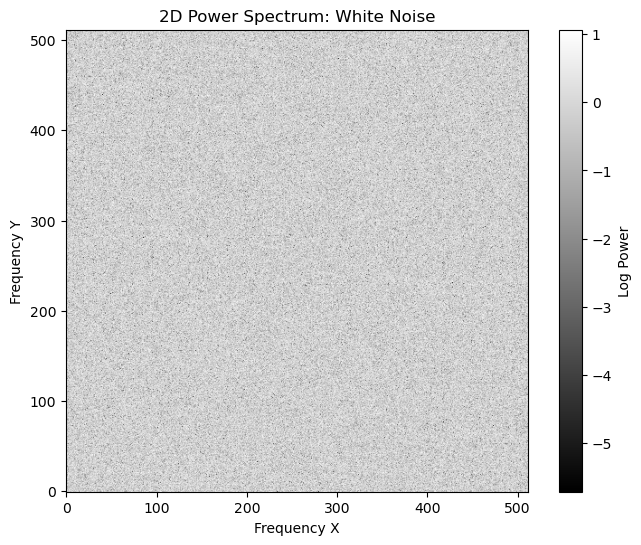

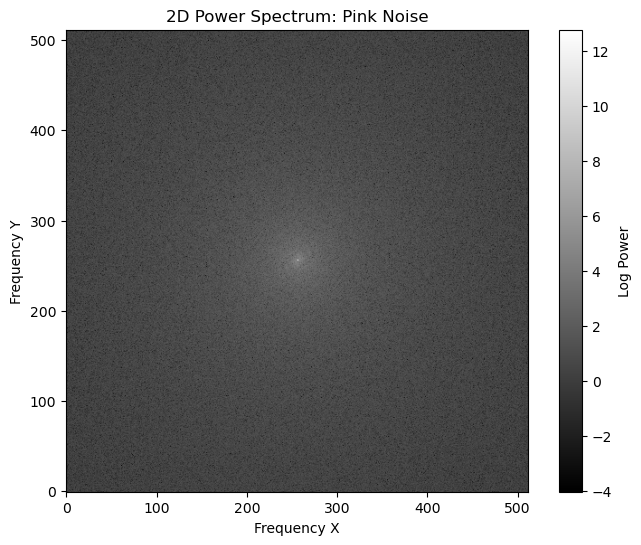

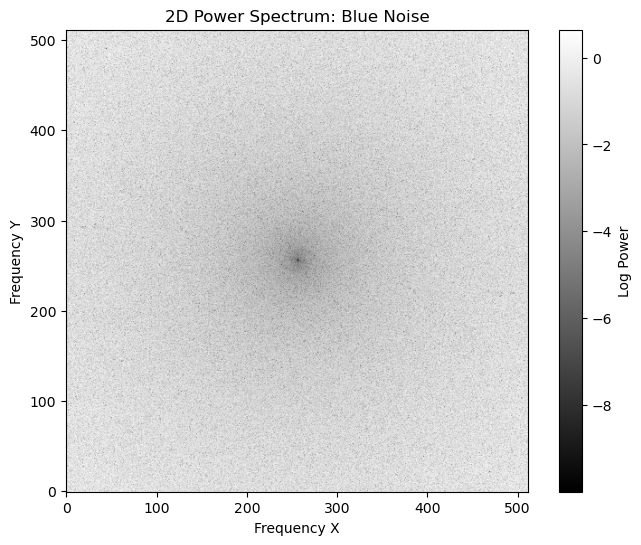

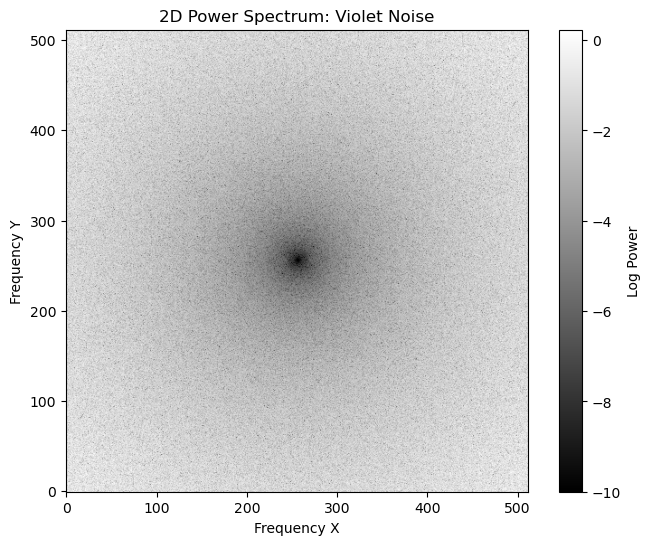

In [3]:
# Plot spectra for each noise type
plot_2d_spectrum(white_proper, "White Noise")
plot_2d_spectrum(pink_proper, "Pink Noise") 
plot_2d_spectrum(blue_proper, "Blue Noise")
plot_2d_spectrum(violet_proper, "Violet Noise")


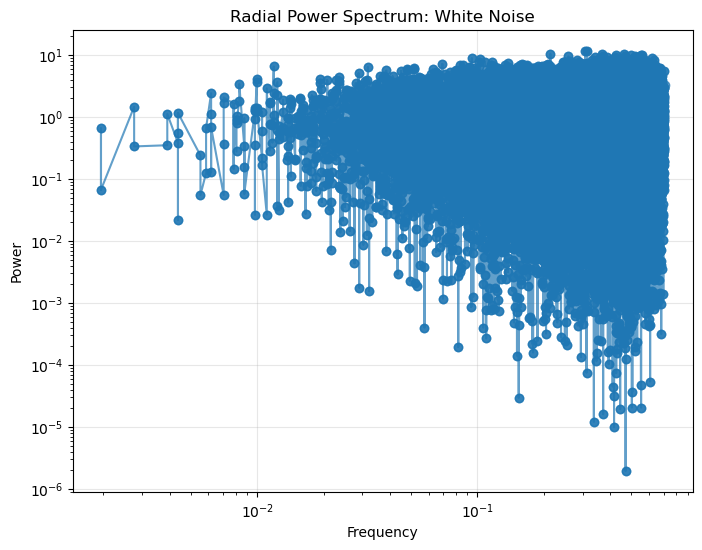

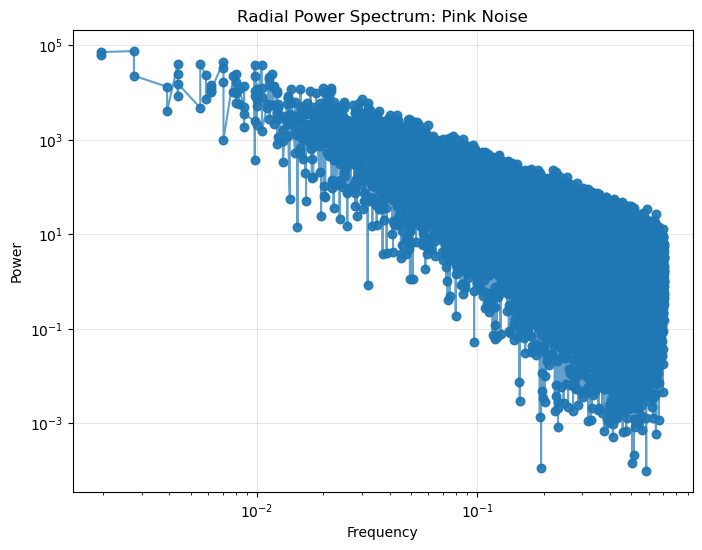

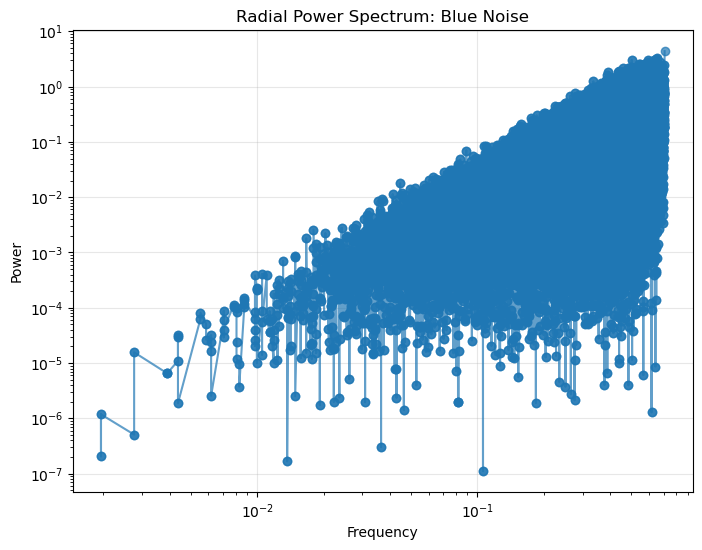

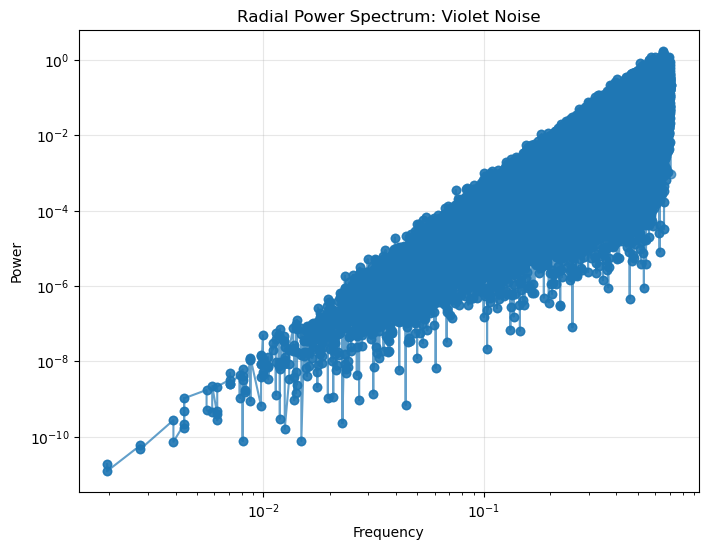

In [4]:
# Plot for each noise type
plot_radial_spectrum(white_proper, "White Noise")
plot_radial_spectrum(pink_proper, "Pink Noise")
plot_radial_spectrum(blue_proper, "Blue Noise") 
plot_radial_spectrum(violet_proper, "Violet Noise")


Now we can look at dithering te different types of noise textures

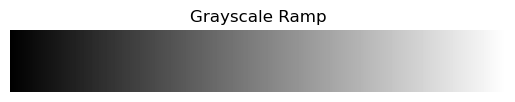

In [5]:
shape = (128, 1024) # np scaling
linear_ramp = create_grayscale_ramp(shape)
plt.imshow(linear_ramp, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("Grayscale Ramp")
plt.axis('off')
plt.show()


[[ 4.35752555e-03  6.34530527e-03  1.74595540e-03 ...  4.77466961e-05
  -5.73050013e-04  5.97785245e-04]
 [ 2.77945935e-03 -3.40297232e-03 -3.48046123e-03 ... -5.92346807e-04
  -2.63539338e-03 -4.08298240e-04]
 [ 1.30087573e-03 -2.50309516e-03  2.99001612e-03 ... -1.21801233e-03
  -2.41694183e-03 -3.34594432e-03]
 ...
 [-3.33577797e-03 -5.32694040e-03  1.88006651e-03 ... -2.11603161e-03
   2.62419240e-03 -2.96635630e-03]
 [ 2.60774585e-03  1.23788298e-03  6.87398152e-04 ...  3.36614331e-03
  -1.91132418e-03  2.03711050e-03]
 [-2.41751048e-03 -4.01497070e-03  2.18384949e-03 ... -1.71256056e-03
   1.05535817e-03 -4.15786080e-03]]


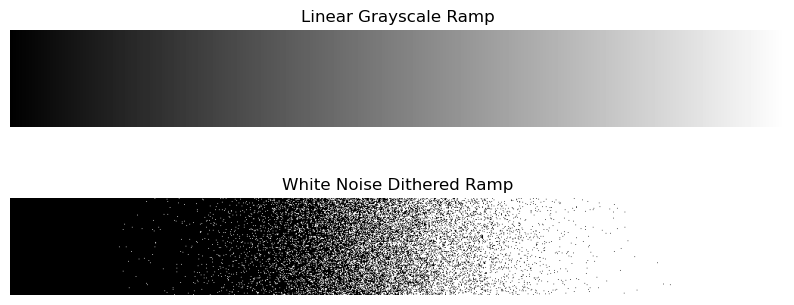

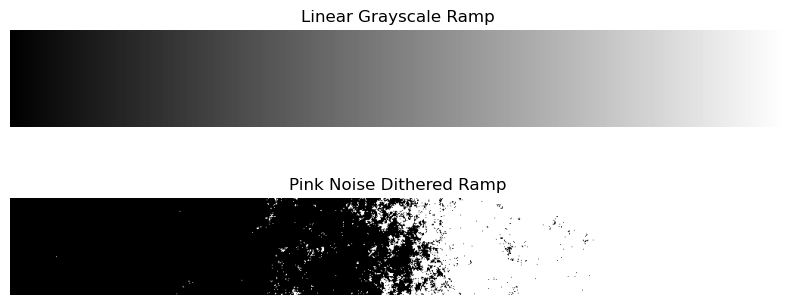

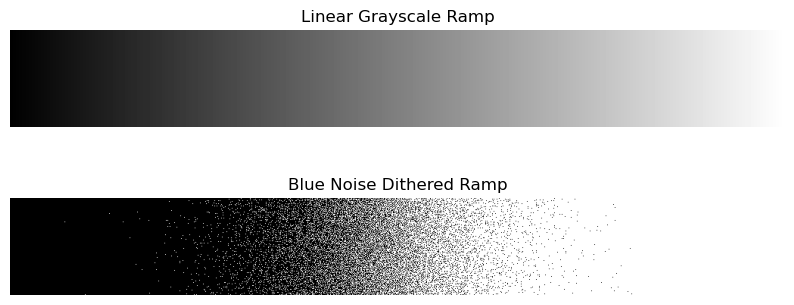

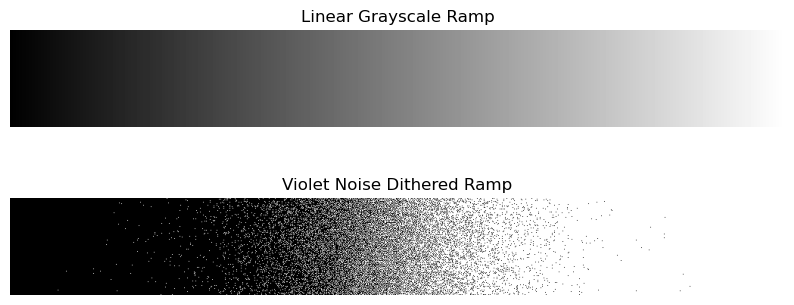

In [6]:
white_noise_ramp = generate_coloured_noise(shape, white_spectrum)
pink_noise_ramp = generate_coloured_noise(shape, pink_spectrum)
blue_noise_ramp = generate_coloured_noise(shape, blue_spectrum)
violet_noise_ramp = generate_coloured_noise(shape, violet_spectrum)


white_noise_normalized = normalize_to_unit_range(white_noise_ramp)
pink_noise_normalized = normalize_to_unit_range(pink_noise_ramp)
blue_noise_normalized = normalize_to_unit_range(blue_noise_ramp)
violet_noise_normalized = normalize_to_unit_range(violet_noise_ramp)

white_dithered_ramp = dither_with_noise(linear_ramp, white_noise_normalized)
pink_dithered_ramp = dither_with_noise(linear_ramp, pink_noise_normalized)
blue_dithered_ramp = dither_with_noise(linear_ramp, blue_noise_normalized)
violet_dithered_ramp = dither_with_noise(linear_ramp, violet_noise_normalized)


plot_two_ramps_vertical(linear_ramp, white_dithered_ramp, "Linear Grayscale Ramp", "White Noise Dithered Ramp")
plot_two_ramps_vertical(linear_ramp, pink_dithered_ramp, "Linear Grayscale Ramp", "Pink Noise Dithered Ramp")
plot_two_ramps_vertical(linear_ramp, blue_dithered_ramp, "Linear Grayscale Ramp", "Blue Noise Dithered Ramp")
plot_two_ramps_vertical(linear_ramp, violet_dithered_ramp, "Linear Grayscale Ramp", "Violet Noise Dithered Ramp")


print(white_noise_ramp)

(-0.5, 511.5, 511.5, -0.5)

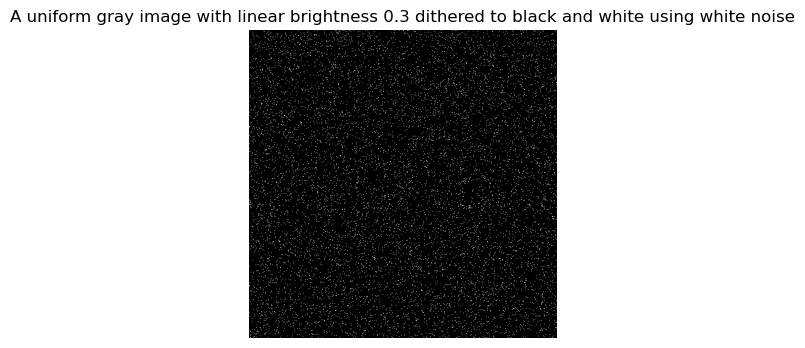

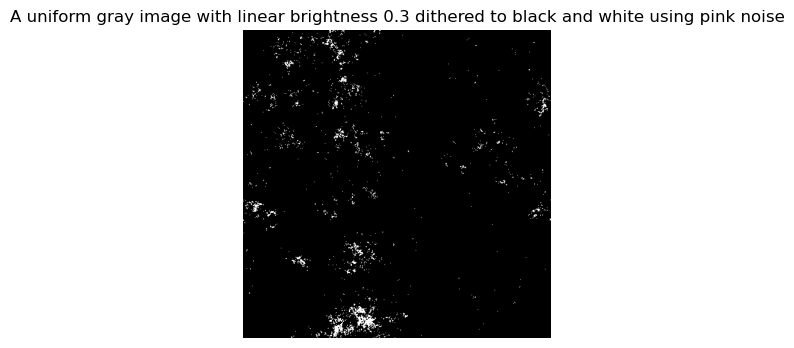

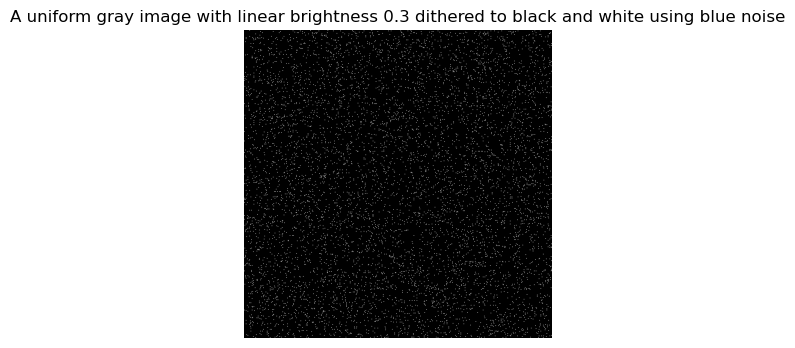

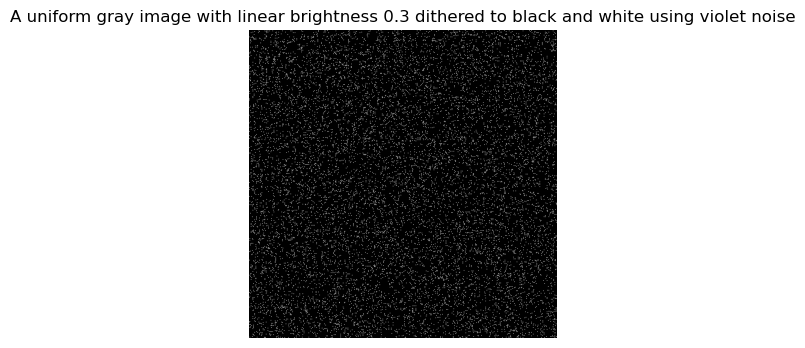

In [7]:
shape = (512, 512)
gray_point3 = create_gray_image(shape, 0.3)
white_noise = generate_coloured_noise(shape, white_spectrum)
pink_noise = generate_coloured_noise(shape, pink_spectrum)
blue_noise = generate_coloured_noise(shape, blue_spectrum)
violet_noise = generate_coloured_noise(shape, violet_spectrum)


white_noise_normalized = normalize_to_unit_range(white_noise)
pink_noise_normalized = normalize_to_unit_range(pink_noise)
blue_noise_normalized = normalize_to_unit_range(blue_noise)
violet_noise_normalized = normalize_to_unit_range(violet_noise)

white_dithered = dither_with_noise(gray_point3, white_noise_normalized)
pink_dithered = dither_with_noise(gray_point3, pink_noise_normalized)
blue_dithered = dither_with_noise(gray_point3, blue_noise_normalized)
violet_dithered = dither_with_noise(gray_point3, violet_noise_normalized)

plt.figure(figsize=(8, 4))
plt.imshow(white_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using white noise")
plt.axis('off')


plt.figure(figsize=(8, 4))
plt.imshow(pink_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using pink noise")
plt.axis('off')


plt.figure(figsize=(8, 4))
plt.imshow(blue_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using blue noise")
plt.axis('off')


plt.figure(figsize=(8, 4))
plt.imshow(violet_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using violet noise")
plt.axis('off')


In [8]:
# Generate a random 512x512 to save
white_noise_ramp = generate_coloured_noise((512, 512), white_spectrum)


### The next cell will generate a bunch of different example white noises at 64x64 and save them.

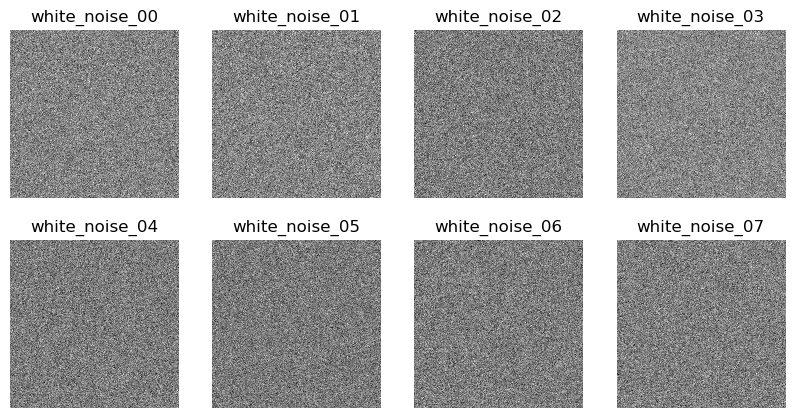

In [ ]:
outpath = "textures/white_noise/64x64"
fig, axes = plt.subplots(2, 4, figsize=(10, 5))  # 2 rows, 4 cols


for i in range(0, 8):
	white_noise = generate_coloured_noise(shape, white_spectrum)
	white_noise_uint8 = cv2.normalize(
		white_noise, None, 0, 255, cv2.NORM_MINMAX
	).astype('uint8')

	# pick subplot without enumerate()
	r, c = divmod(i, 4)         # row, col
	ax = axes[r, c]
	ax.imshow(white_noise, cmap="gray", interpolation="nearest")
	ax.set_title(f"white_noise_{i:02d}")
	ax.axis("off")

	# save with different names
	cv2.imwrite(os.path.join(outpath, f"white_noise_{i:02d}.png"), white_noise_uint8)
